In [2]:
using Gadfly, DataFrames, DataArrays, Cairo, Images, ImageMagick, MultivariateStats, Colors;

In [91]:
set_default_plot_size(25cm, 20cm);

# Prerequisites

## Functions for evaluation

We'll define a few functions here to compute the mean F1 score

$$F1 = 2\frac{p * r}{p + r} \quad \text{where } p = \frac{tp}{tp + fp} \text{, }\quad r = \frac{tp}{tp + fn}$$

In [92]:
truePositives(y_true, y_pred, label) = sum(
    (y_pred .== label) & (y_true .== label));

In [93]:
falsePositives(y_true, y_pred, label) = sum(
    (y_pred .== label) & !(y_true .== label));

In [94]:
falseNegatives(y_true, y_pred, label) = sum(
    !(y_pred .== label) & (y_true .== label));

In [95]:
function precision(y_true, y_pred, label)
    tp = truePositives(y_true, y_pred, label)
    fp = falsePositives(y_true, y_pred, label)
    return tp / (tp + fp)
end;

In [96]:
function recall(y_true, y_pred, label)
    tp = truePositives(y_true, y_pred, label)
    fn = falseNegatives(y_true, y_pred, label)
    return tp / (tp + fn)
end;

In [97]:
function meanF1Score(y_true, y_pred, label)
    classes = sort(unique([unique(y_true);unique(y_pred)]))
    f1 = 0
    for class in classes
        p = precision(y_true, y_pred, label)
        r = recall(y_true, y_pred, label)
        f1 += 2 * ((p * r)/(p + r))        
    end
    return f1 / length(classes)
end;

Also we could use a function for the confusion matrix

In [98]:
function confusionMatrix(y_true, y_pred)
    classes = sort(unique([unique(y_true),unique(y_pred)]))
    confusion_matrix = zeros(Int64,length(classes),length(classes))
    for i in 1:length(y_true)
        # translate label into index
        true_class = findfirst(classes,y_test[i])
        pred_class = findfirst(classes,y_pred[i])
        # pred class is the row, true class is the column
        cm[pred_class,true_class] += 1
    end
    return confusion_matrix
end;

## Functions for cross-validation

### Generating k folds by splitting the data in test and training set

A function to generate vectors for splitting the dataset for cross validation each vector selects the datapoints for the test set.

In [99]:
# data_size: data points / rows in dataset
# folds: number of split vectors to be used for CV folds
# test_size_ratio: percentage of dataset to be in test set
function getCVSplits(data_size=5000, folds=5, test_size_ratio=0.25)
    splits = []
    for k in range(1,folds)
        is_train = shuffle(
            range(1, data_size) .> floor(data_size * test_size_ratio))
        push!(splits, is_train)
    end
    return splits
end;

A function that splits our dataset with a boolean vector into test and training set:

In [100]:
# splitvectors: boolean vector that selects which entries are in 
#              test/training set, can be obtained using getCVSplits()
# X: feature matrix DataFrame
# Y: target matrix DataFrame
function splitDataset(splitvector, X, Y)
    X_train_df = X[splitvector,:]
    X_test_df  = X[!splitvector,:]
    Y_train_df = Y[splitvector, :]
    Y_test_df  = Y[!splitvector, :]
    return (X_train_df, X_test_df, Y_train_df, Y_test_df)
end;

### Generating feature matrix and target vectors from split data

A function to get the feature matrix with added bias

In [101]:
getFeatureMatrix(Xdf) = hcat(ones(nrow(Xdf), 1), Matrix(Xdf));

A funtion to get the target vector for predicting the type of wine (classification task)

In [102]:
# assign class labels -1.0 for Red and 1.0 for White
function getTargetTypeVector(Ydf)
    Y = ones(nrow(Ydf))
    is_white = collect(Matrix(Ydf[:,2:2]) .== "White")
    Y[!is_white,:] = -1.0;
    return Y
end;

A funtion to get the target vector for predicting the quality of wine (regression task)

In [103]:
getTargetQualityVector(Ydf) = Matrix(Ydf[:,1:1]);

And finally a function to generate all the matrices and vectors from a split:

In [104]:
function getFold(splitvector, X, Y)
    (X_train_df, X_test_df, Y_train_df, Y_test_df) = splitDataset(
        splitvector, X, Y)
    
    X_train = getFeatureMatrix(X_train_df);
    X_test = getFeatureMatrix(X_test_df);

    y_type_train = getTargetTypeVector(Y_train_df);
    y_type_test = getTargetTypeVector(Y_test_df);
    y_quality_train = getTargetQualityVector(Y_train_df);
    y_quality_test = getTargetQualityVector(Y_test_df);
    
    return (X_train, X_test, y_type_train, y_type_test,
        y_quality_train, y_quality_test)    
end;

## Data preparation

Read the data into DataFrames:

In [105]:
df_labelled = readtable(
    "data/training_classification_regression_2015.csv");

In [106]:
df_unlabelled = readtable(
    "data/challenge_public_test_classification_regression_2015.csv");
# data has a weird extra id field that needs to be dropped
df_unlabelled = df_unlabelled[:,2:14];

The columns in the data are:

In [107]:
names(df_labelled)

13-element Array{Symbol,1}:
 :fixedAcidity      
 :volatileAcidity   
 :citricAcid        
 :residualSugar     
 :chlorides         
 :freeSulfurDioxide 
 :totalSulfurDioxide
 :density           
 :pH                
 :sulphates         
 :alcohol           
 :quality           
 :_type             

We'll use the first 11 as feature variables

In [108]:
variables = names(df_labelled)[1:11];

We normalize the features by subtracting from each column its mean and deviding by its standard deviation. We normalize over all rows in both unlabelled and labelled data to avoid being biased by the selection of training vs target set.

In [21]:
df_labelled_norm = deepcopy(df_labelled)
df_unlabelled_norm = deepcopy(df_unlabelled)
df_full = vcat(df_labelled_norm, df_unlabelled_norm)
for variable in variables
    column_full       = df_full[:, variable] 
    column_labelled   = df_labelled_norm[:, variable] 
    column_unlabelled = df_unlabelled_norm[:, variable]   
    df_labelled_norm[:, variable] = (
        column_labelled .- mean(column_full)) ./ std(column_full)
    df_unlabelled_norm[:, variable] = (
        column_unlabelled .- mean(column_full)) ./ std(column_full)
end

Stack up the features for easier visualization

In [22]:
df_labelled_norm_stacked = stack(df_labelled_norm, variables);

Seperating features and labels for training and testing (labelled) and for submission (unlabelled). 

In [23]:
X_df_labelled = df_labelled_norm[:,1:11]
Y_df_labelled = df_labelled_norm[:,12:13]

X_df_unlabelled = df_unlabelled_norm[:,1:11]
size(X_df_unlabelled)

(1000,11)

# Visualizations

## Classification

A placeholder plot we'll use to fill up grids

In [24]:
placeholder = plot(x=[0], y=[0], Guide.xlabel(nothing), 
    Guide.yticks(ticks=nothing), Guide.xticks(ticks=nothing), 
    Guide.ylabel(nothing));

Plotting all classes for all variables

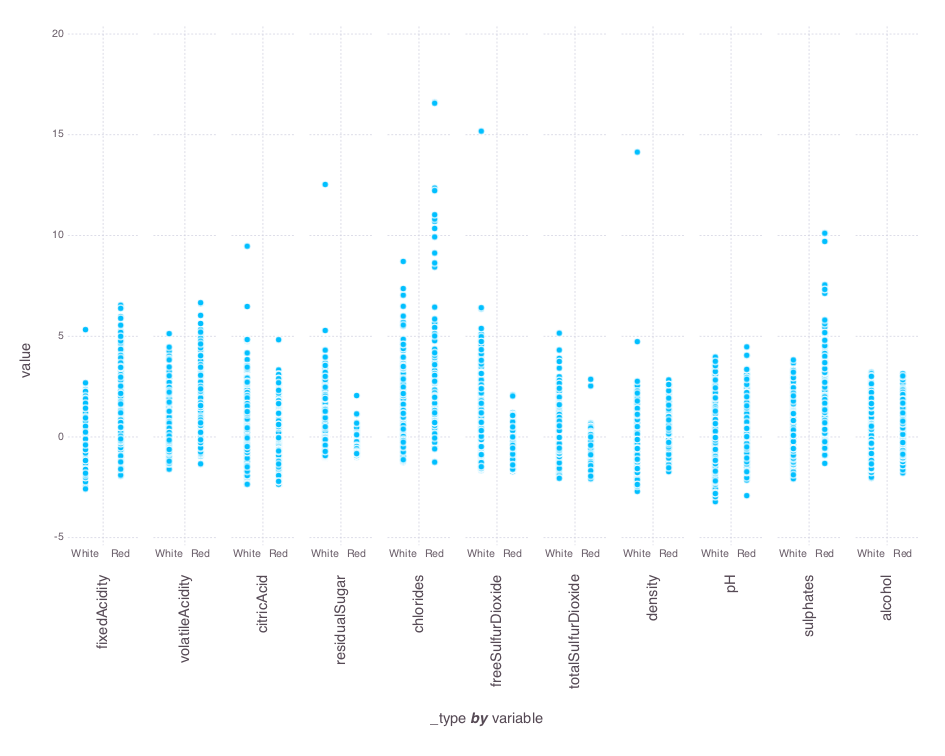

In [25]:
filename = "hist_variables_type"
p = plot(df_labelled_norm_stacked,
xgroup="variable", x="_type", y="value", Geom.subplot_grid(Geom.point));
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 25cm, 20cm), p)
load(string("plots/", filename, ".png"))

Now each seperately 

In [26]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_labelled_norm_stacked[
        (df_labelled_norm_stacked[:variable].==variable), :] 
    push!(plots, plot(feature, x=:_type, y=:value, Geom.point, 
        Guide.xlabel(string(variable), orientation=:horizontal)))
end
push!(plots, placeholder);

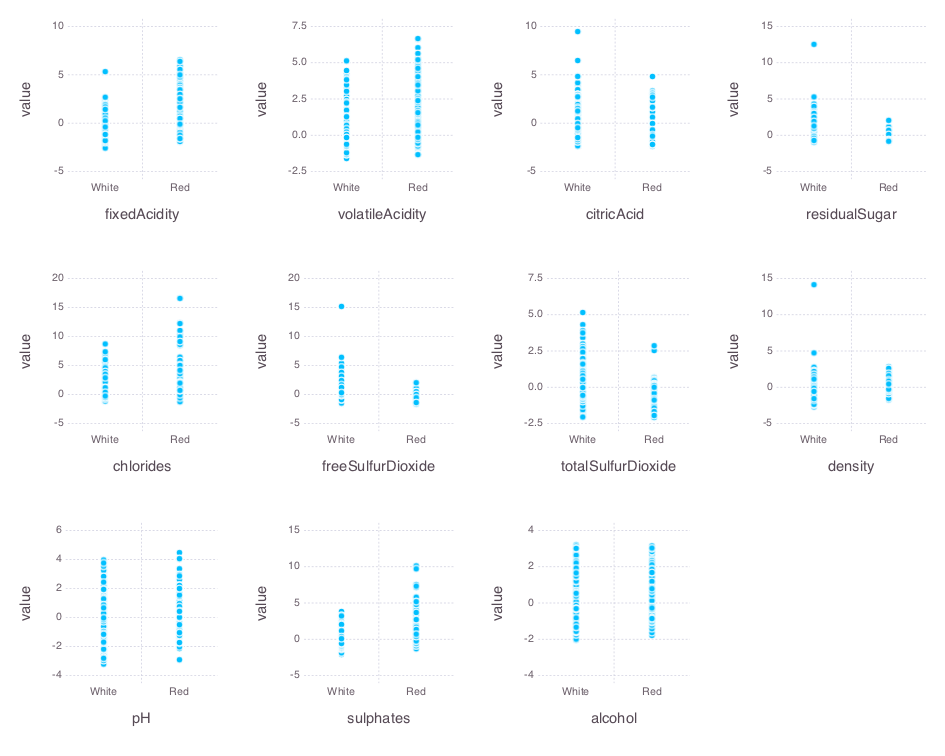

In [27]:
filename = "hist_variables_type_grid"

plotstack = vstack(
    hstack(plots[1], plots[2], plots[3], plots[4]),
    hstack(plots[5], plots[6], plots[7], plots[8]),
    hstack(plots[9], plots[10], plots[11], plots[12]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 20cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 20cm), plotstack)
load(string("plots/", filename, ".png"))

The features look somewhat seperable, let's look at the density

In [28]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_labelled_norm_stacked[
        (df_labelled_norm_stacked[:variable].==variable), :] 
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

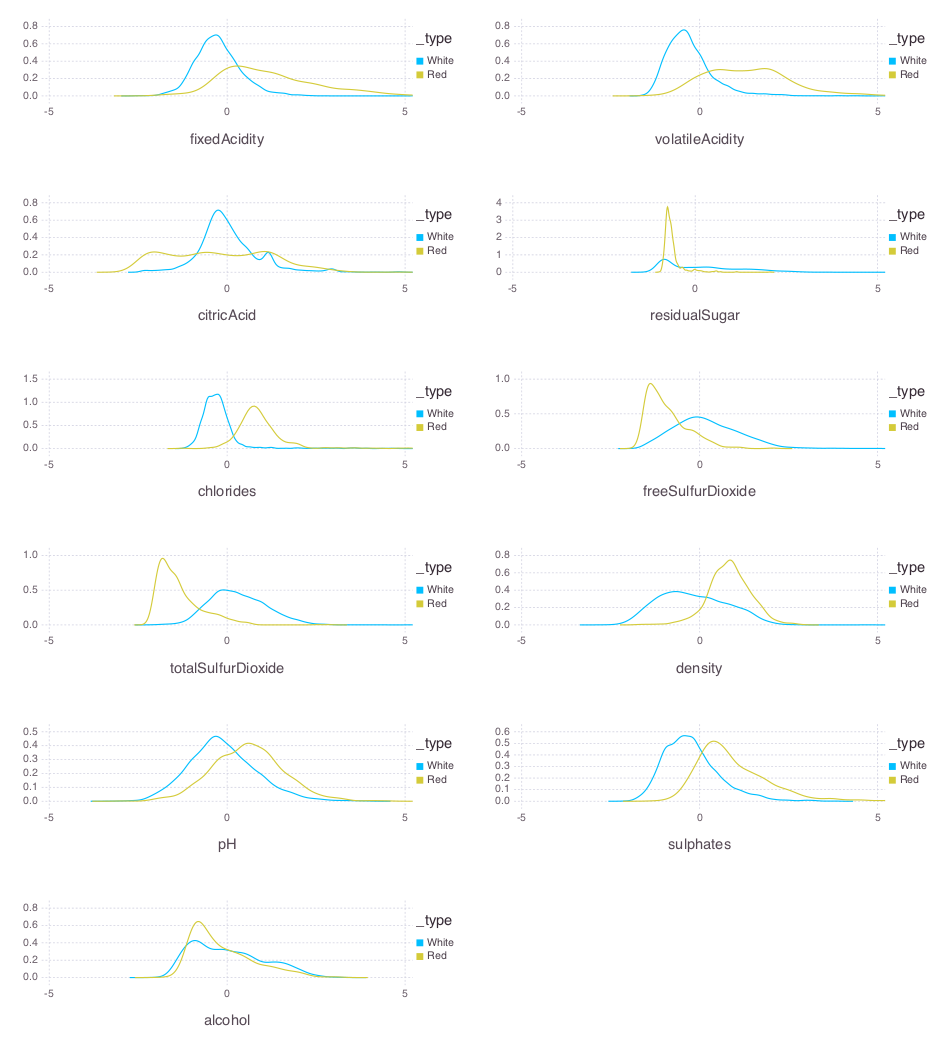

In [29]:
filename = "density_type_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
load(string("plots/", filename, ".png"))

Seems like there a good binary seperation should be possible. Let's look at the density distribution of the quality labels:

In [30]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_labelled_norm_stacked[
        (df_labelled_norm_stacked[:variable].==variable), :] 
    
    push!(plots, plot(feature, color=:quality, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Scale.ContinuousColorScale(
        Scale.lab_gradient(colorant"orange", colorant"blue")),
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

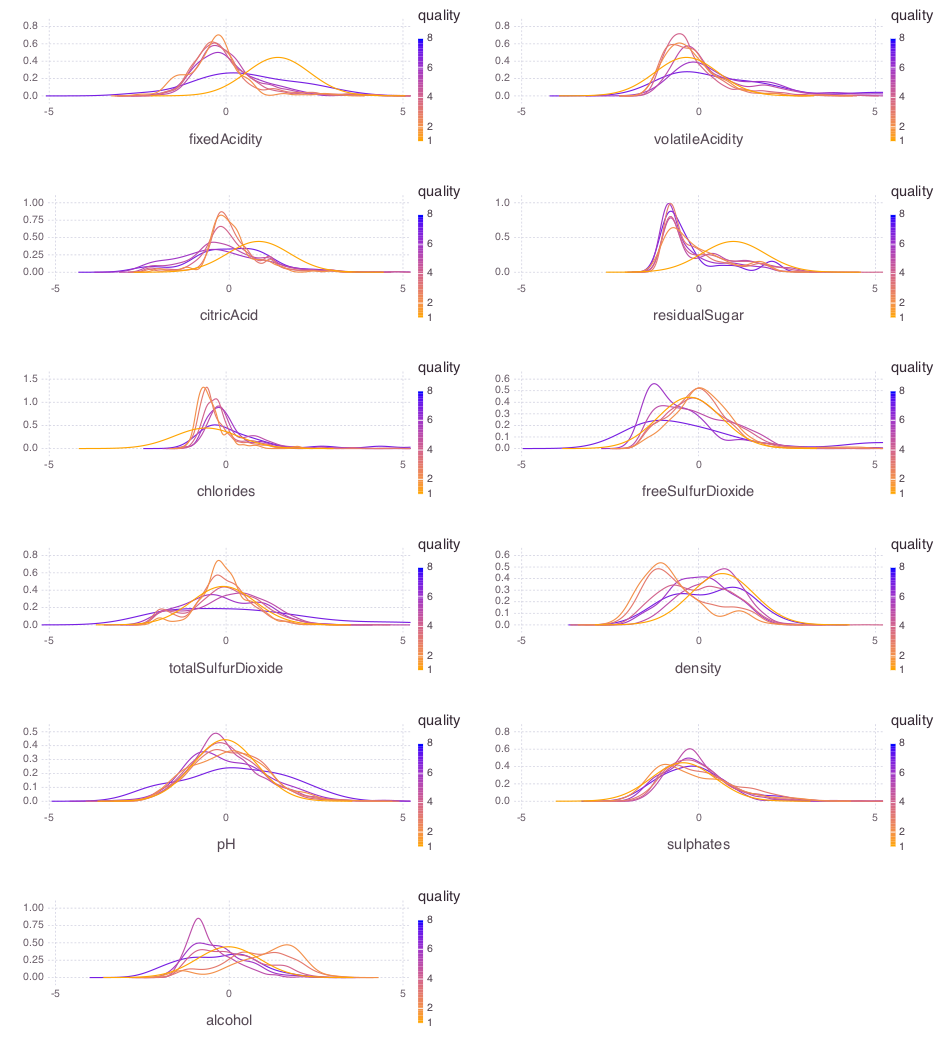

In [31]:
filename = "density_quality_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
load(string("plots/", filename, ".png"))

## PCA

In [32]:
# train a PCA model
X_matrix = Matrix(deepcopy(X_df_labelled))
M = fit(PCA, X_matrix'; maxoutdim=6, method=:auto)
pca_matrix = transform(M, X_matrix')';

In [33]:
# make it a DataFrame and merge it with the labels
df_pca = DataFrame(pca_matrix)
df_pca_labelled = hcat(df_pca, Y_df_labelled)
names(df_pca_labelled);

Plot first 2 principal components:

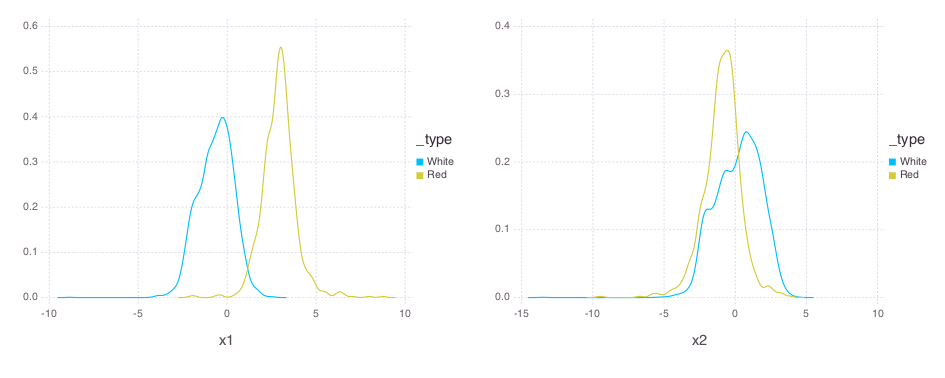

In [34]:
filename = "density_pca_type_2first"
p1 = plot(df_pca_labelled, color=:_type, x=:x1, Geom.density)
p2 = plot(df_pca_labelled, color=:_type, x=:x2, Geom.density)
plotstack = hstack(p1, p2)

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 10cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 10cm), plotstack)
load(string("plots/", filename, ".png"))

First 2 components on a plane

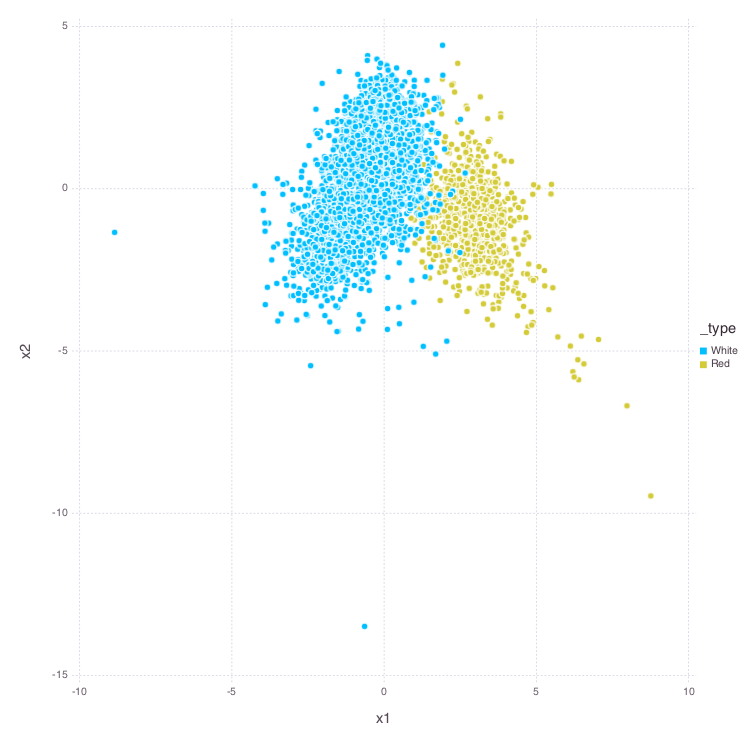

In [35]:
filename = "scatter_pca_type_2first"
p = plot(df_pca_labelled, color=:_type, x=:x1, y=:x2, Geom.point)
draw(PDF(string("plots/", filename, ".pdf"), 20cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 20cm, 20cm), p)
load(string("plots/", filename, ".png"))

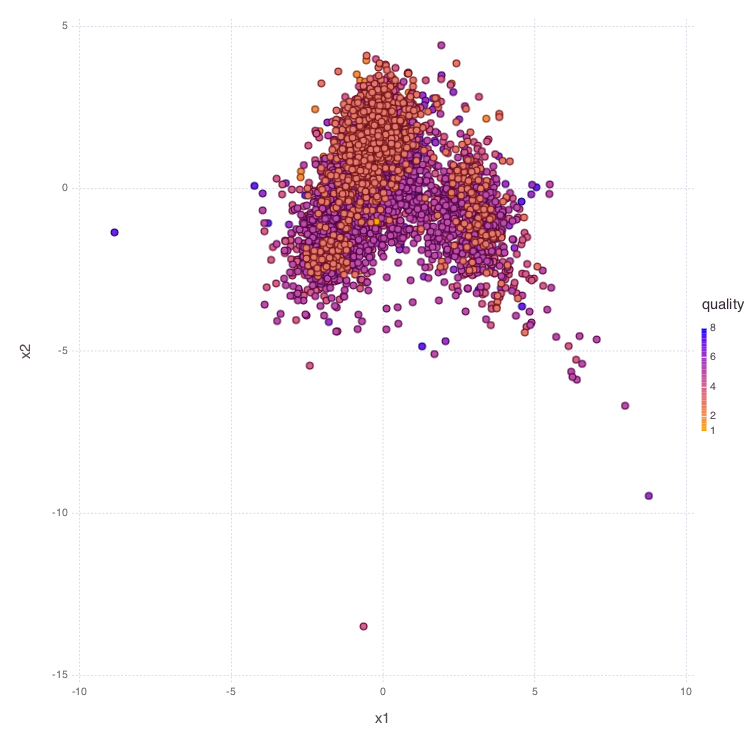

In [36]:
filename = "scatter_pca_quality_2first"
p = plot(df_pca_labelled, color=:quality, x=:x1, y=:x2, Geom.point, 
    Scale.ContinuousColorScale(
    Scale.lab_gradient(colorant"orange", colorant"blue")))
draw(PDF(string("plots/", filename, ".pdf"), 20cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 20cm, 20cm), p)
load(string("plots/", filename, ".png"))

In [37]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
df_pca_labelled_stacked = stack(df_pca_labelled, variables)

for variable in variables
    feature = df_pca_labelled_stacked[
        (df_pca_labelled_stacked[:variable].==variable), :]     
    push!(plots, plot(feature, color=:quality, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Scale.ContinuousColorScale(
        Scale.lab_gradient(colorant"orange", colorant"blue")),
    Coord.cartesian(xmin=-5, xmax=5)))
end
# push!(plots, placeholder);

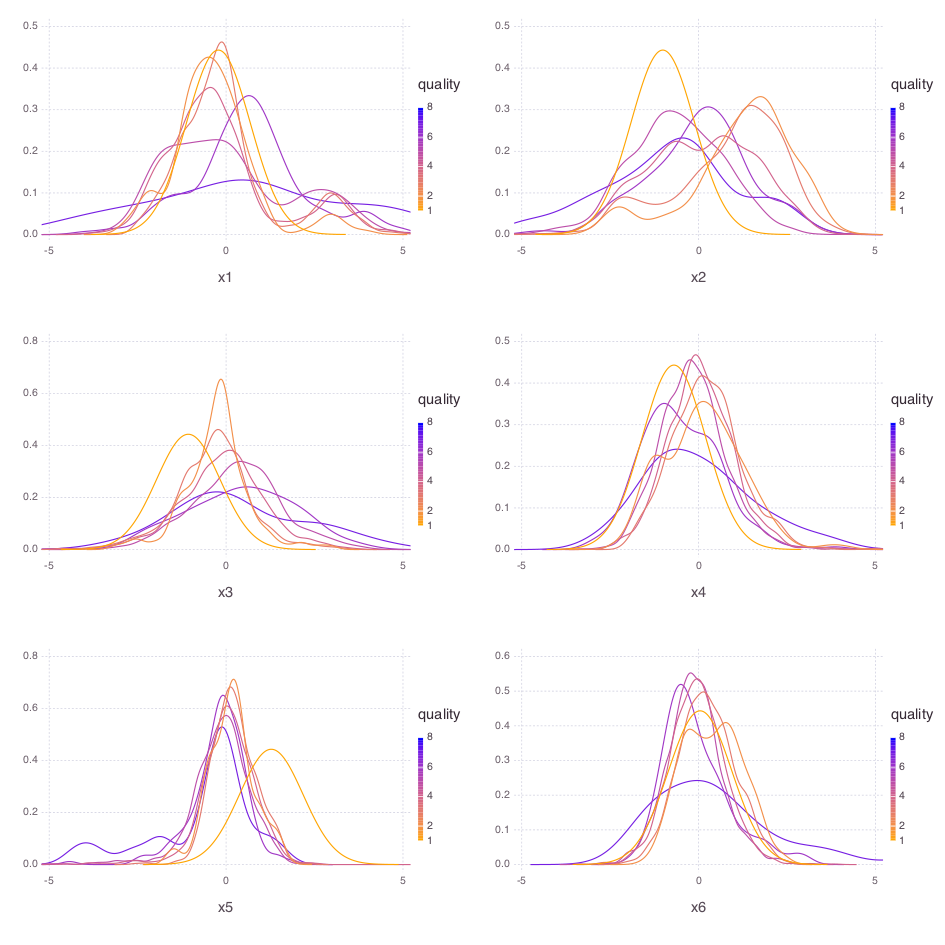

In [38]:
filename = "density_pca_quality_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))
#     hstack(plots[7], plots[7]),
#     hstack(plots[8], plots[9]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

In [39]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
df_pca_labelled_stacked = stack(df_pca_labelled, variables)

for variable in variables
    feature = df_pca_labelled_stacked[
        (df_pca_labelled_stacked[:variable].==variable), :]     
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end

 in depwarn at deprecated.jl:73
 in imread at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/cwestrup/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/cwestrup/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[38], in expression starting on line 10


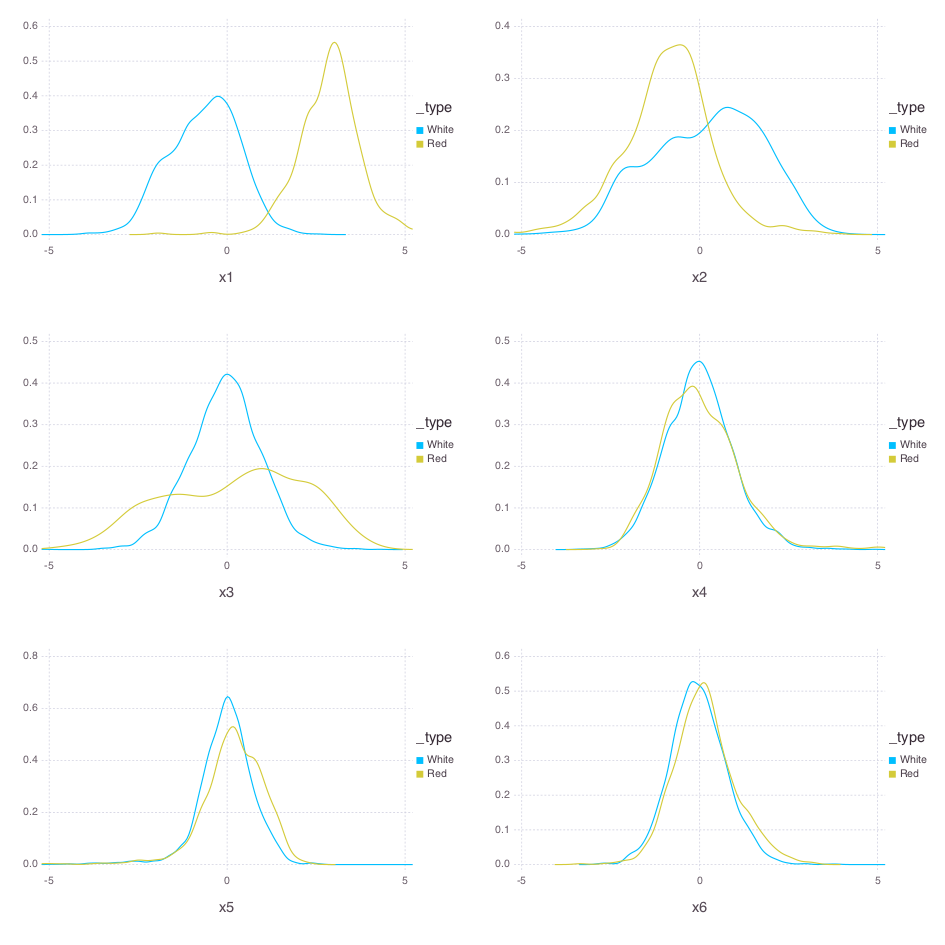

In [40]:
filename = "density_pca_type_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

# ICA

In [41]:
# train a ICA model
X_matrix = Matrix(deepcopy(X_df_labelled))
M = fit(ICA, X_matrix', 6)
ica_matrix = transform(M, X_matrix')';

In [42]:
df_ica = DataFrame(ica_matrix)
df_ica_labelled = hcat(df_ica, Y_df_labelled);

In [43]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
for variable in variables
    push!(plots, plot(df_ica_labelled, color=:_type, 
        x=variable, Geom.density,
        Guide.xlabel(string(variable), orientation=:horizontal),
        Coord.cartesian(xmin=-5, xmax=5)))
end

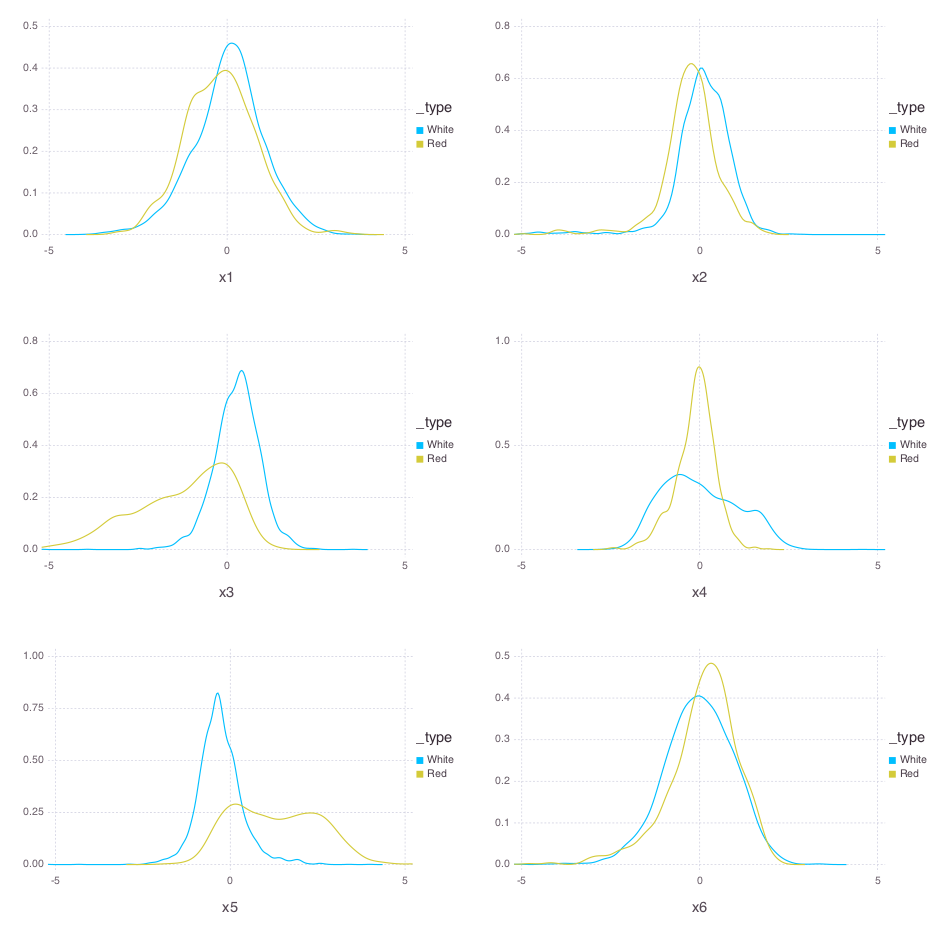

In [44]:
filename = "density_ica_type_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

In [45]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
for variable in variables
    push!(plots, plot(df_ica_labelled, color=:quality, 
        x=variable, Geom.density,
        Guide.xlabel(string(variable), orientation=:horizontal),
        Scale.ContinuousColorScale(
            Scale.lab_gradient(colorant"orange", colorant"blue")),
        Coord.cartesian(xmin=-5, xmax=5)))
end

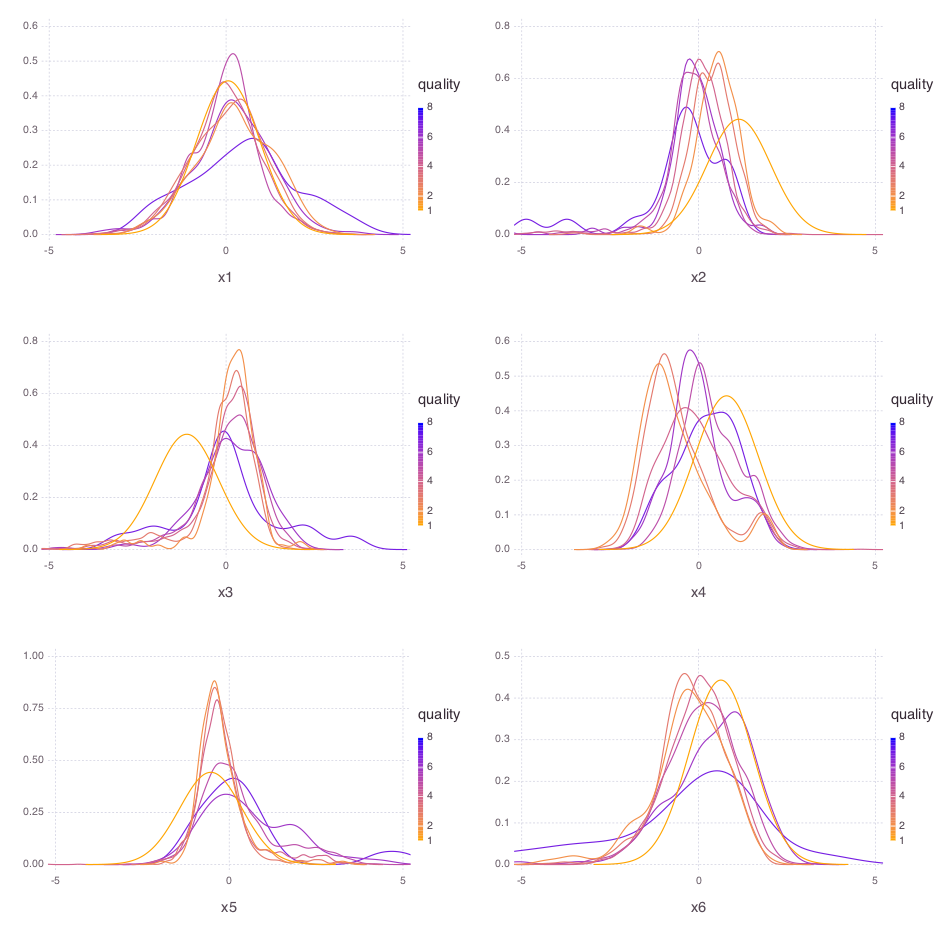

In [46]:
filename = "density_ica_quality_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

# Linear regression

### Description 

(*Add reference to Bishop)

Train the weights throught the closed-form solution using the pseudo-inverse matrix of $X$

$w(X,Y) = (X^Y X)^{-1} X^Y = X^\dagger Y$

In [47]:
wLinearRegression(X, Y) = pinv(X)*Y;

We can then make predictions using these weights:

$y(X, w) = Xw $

In [48]:
yLinearRegression(X, w) = X*w;

### Test

Generate dataset:

In [109]:
split = getCVSplits()[1]
(X_train, 
 X_test, 
 y_type_train, 
 y_type_test,
 y_quality_train, 
 y_quality_test) = getFold(
    split, X_df_labelled, Y_df_labelled);

Train our weights:

In [110]:
w = wLinearRegression(X_train, y_type_train);

Make predictions:

In [111]:
y_pred = sign(yLinearRegression(X_test, w));

F1 score (white wine):

In [112]:
meanF1Score(y_pred, y_type_test, 1.0)

0.9975833736104397

F1 score (red wine):

In [113]:
meanF1Score(y_pred, y_type_test, -1.0)

0.988399071925754

### Plot decision boundaries

In [114]:
plots = Gadfly.Plot[]

for (index, variable) in enumerate(variables)
    feature = df_labelled_norm_stacked[
        (df_labelled_norm_stacked[:variable].==variable), :] 
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    xintercept=[w[index+1]], Geom.vline,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

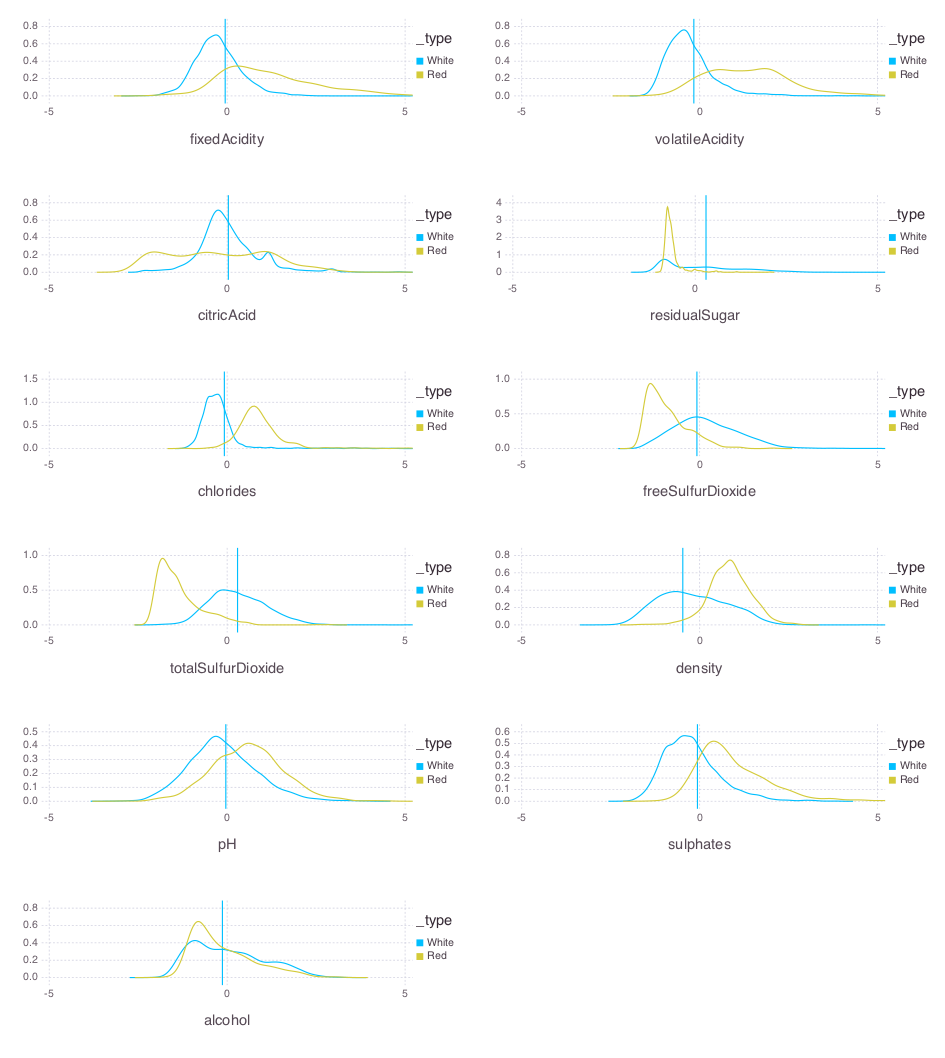

In [115]:
filename = "decision_boundaries_lin_reg_grid"

plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
load(string("plots/", filename, ".png"))

### Test with PCA

In [116]:
split = getCVSplits()[1]
(X_train, 
 X_test, 
 y_type_train, 
 y_type_test,
 y_quality_train, 
 y_quality_test) = getFold(
    split, X_df_labelled, Y_df_labelled);

In [117]:
w = wLinearRegression(X_train, y_type_train);
y_pred = sign(yLinearRegression(X_test, w));
meanF1Score(y_pred, y_type_test, 1.0)

0.9960707269155207

Slightly worse predictions! Let's only try the first component:

In [118]:
# Split for training and test set
n = nrow(X_df_labelled)
splits = getCVSplits(n, 1, 0.25)

# Create dataframes with training and test sets:
(X_train_df, X_test_df, Y_train_df, Y_test_df) = splitDataset(
splits[1], df_pca[:,1:1], Y_df_labelled);

# generate feature matrix and target vector
X_train = getFeatureMatrix(X_train_df);
X_test = getFeatureMatrix(X_test_df);
y_type_train = getTargetTypeVector(Y_train_df);
y_type_test = getTargetTypeVector(Y_test_df);

In [119]:
w = wLinearRegression(X_train, y_type_train);
y_pred = sign(yLinearRegression(X_test, w));
meanF1Score(y_pred, y_type_test, 1.0)

0.9891046897205116

A little worse, but pretty good predictions for a single feature

And we have predicted the following number of white wines in 1250:

In [120]:
sum(y_pred .== 1.0)

1059

### Test with cross-validation:

In [121]:
# Split for training and test set
n = nrow(X_df_labelled)
folds = 50
splits = getCVSplits(n, folds, 0.20)

mean_f1_white = 0
mean_f1_red = 0

for split in splits
    # Create dataframes with training and test sets:
    (X_train, 
     X_test, 
     y_type_train, 
     y_type_test,
     y_quality_train, 
     y_quality_test) = getFold(
        split, X_df_labelled, Y_df_labelled);
    
    # predict 
    w = wLinearRegression(X_train, y_type_train);
    y_pred = sign(yLinearRegression(X_test, w));

    # score
    mean_f1_white += meanF1Score(y_pred, y_type_test, 1.0)
    mean_f1_red += meanF1Score(y_pred, y_type_test, 1.0)

end
println("F1 score (CV with ", folds, 
    " folds) for white wines: ", mean_f1_white / folds)
println("F1 score (CV with ", folds, 
    " folds) for red wines: ", mean_f1_red / folds)

F1 score (CV with 50 folds) for white wines: 0.9962208499065008
F1 score (CV with 50 folds) for red wines: 0.9962208499065008


Given these results we can assume that a simple linear regression gives us very good results even without any dimensionality reduction or preprocessing.

### Predict on submission data

Prepare data, using the full labelled data to train now.

In [140]:
X_train = getFeatureMatrix(X_df_labelled);
X_target = getFeatureMatrix(X_df_unlabelled);
y_type_train = getTargetTypeVector(Y_df_labelled);

In [141]:
w = wLinearRegression(X_train, y_type_train);
y_pred = sign(yLinearRegression(X_target, w));

Number of white wines predicted:

In [142]:
sum(y_pred .== 1.0)

816

Label the wines correctly for submission:

In [146]:
labels = fill("White", length(y_pred))
labels[collect(y_pred .== -1.0)] = "Red";

Prepare a DataFrame and save it into a file

In [163]:
results_df = DataFrame()
results_df[:id] = collect(1:length(labels))
results_df[:type] = labels
writetable("results/type_linear_regression.csv", results_df);

# Logistic regression

Let's implement logistic regression from scratch to start simple:

$g(x) =  \sum_{i=0}^k w_i Φ_i(x)$, with $Φ_0(x) = 0$

# Neural Network

### Backpropagation:

Number of features is the size of the training set columns, without the id, type and quality columns

In [67]:
num_of_features = size(df_train,2)-3

LoadError: LoadError: UndefVarError: df_train not defined
while loading In[67], in expression starting on line 1

Specify the architechture. We'll have a fully connected MLP with 1 hidden layer.

In [68]:
hidden_layers = 1;
hidden_units = 20;
num_of_outputs = 1;

Initialize the weight matrices randomly

In [69]:
using Distributions 
θ1 = rand(Uniform(-1, 1), hidden_units + 1, num_of_features + 1);
θ1[1, :] = 1;
θ1

LoadError: LoadError: UndefVarError: num_of_features not defined
while loading In[69], in expression starting on line 2

In [70]:
θ2 = rand(Uniform(-1, 1), num_of_outputs, hidden_units + 1);

In [71]:
size(θ1), size(θ2)

LoadError: LoadError: UndefVarError: θ1 not defined
while loading In[71], in expression starting on line 1

In [72]:
x = rand(10)

10-element Array{Float64,1}:
 0.725913
 0.700254
 0.308778
 0.837687
 0.823358
 0.144578
 0.456374
 0.276053
 0.984004
 0.834809

In [73]:
x = [1;x]

11-element Array{Float64,1}:
 1.0     
 0.725913
 0.700254
 0.308778
 0.837687
 0.823358
 0.144578
 0.456374
 0.276053
 0.984004
 0.834809

In [74]:
tanh(θ1 * x)

LoadError: LoadError: UndefVarError: θ1 not defined
while loading In[74], in expression starting on line 1

In [75]:
function forwardprop(x,θ)
    tanh(θ ⋅ x)
end

forwardprop (generic function with 1 method)